## 运行环境安装

推荐直接下载各种库都预装好的 Anaconda 2，下载地址 https://www.anaconda.com/download/#macos ，注意选 Python 2.7 version。下载后直接点击执行安装。

## 本教程打开访问

如果不需要运行，只是看执行结果，直接可以从 github 在线地址 https://github.com/justinxcwan/machine-learning-tutorial 上看

如果需要运行，依次执行
```sh
$ git clone https://github.com/justinxcwan/machine-learning-tutorial.git 
$ cd machine-learning-tutorial
machine-learning-tutorial$ jupyter notebook
```

然后打开本教程文件

## 教程大纲

不涉及到任何算法原理，单纯演示如何以黑箱方式使用分类算法。涉及的知识点包括：

1.  Python 常用的机器学习库
2.  分类算法基本流程
3.  特征与特征工程
4.  可视化辅助特征工程
5.  训练集与测试集
6.  XGBoost 分类算法自动调参数
7.  交叉验证
6.  如何评价分类算法的结果

In [1]:
# 直接用 Linux 命令行看文件大小
!ls -lh data

total 12352
-rw-r--r--@ 1 justinwan  staff   3.8M Aug 11  1996 adult.data
-rw-r--r--@ 1 justinwan  staff   1.9M Aug 11  1996 adult.test


In [2]:
# 文件内容，方便确定文件格式
! head -n 2 data/adult.data data/adult.test

==> data/adult.data <==
39, State-gov, 77516, Bachelors, 13, Never-married, Adm-clerical, Not-in-family, White, Male, 2174, 0, 40, United-States, <=50K
50, Self-emp-not-inc, 83311, Bachelors, 13, Married-civ-spouse, Exec-managerial, Husband, White, Male, 0, 0, 13, United-States, <=50K

==> data/adult.test <==
|1x3 Cross validator
25, Private, 226802, 11th, 7, Never-married, Machine-op-inspct, Own-child, Black, Male, 0, 0, 40, United-States, <=50K.


In [3]:
# 看起来训练、测试文件都是 CSV 格式，就直接使用 Pandas 读入成 DataFrame 对象
import numpy as np
import pandas as pd

train_set = pd.read_csv('data/adult.data', header = None)
test_set = pd.read_csv('data/adult.test',
                      skiprows = 1, header = None) # 去掉 adult.test 额外有的头一行

# Pandas 的数据和 Spark 一样，基础单位都是 DataFrame，可以简单理解成就是一张表格
type(train_set)

pandas.core.frame.DataFrame

In [4]:
# 训练集的数据
train_set.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
# 测试集的数据，注意和训练集不同，‘50K’ 后面带了 ‘.’。后面会处理写法不统一的问题。
test_set.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [6]:
# 加上字段名，避免靠字段ID来记字段内容

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']

train_set.columns = col_labels
test_set.columns = col_labels

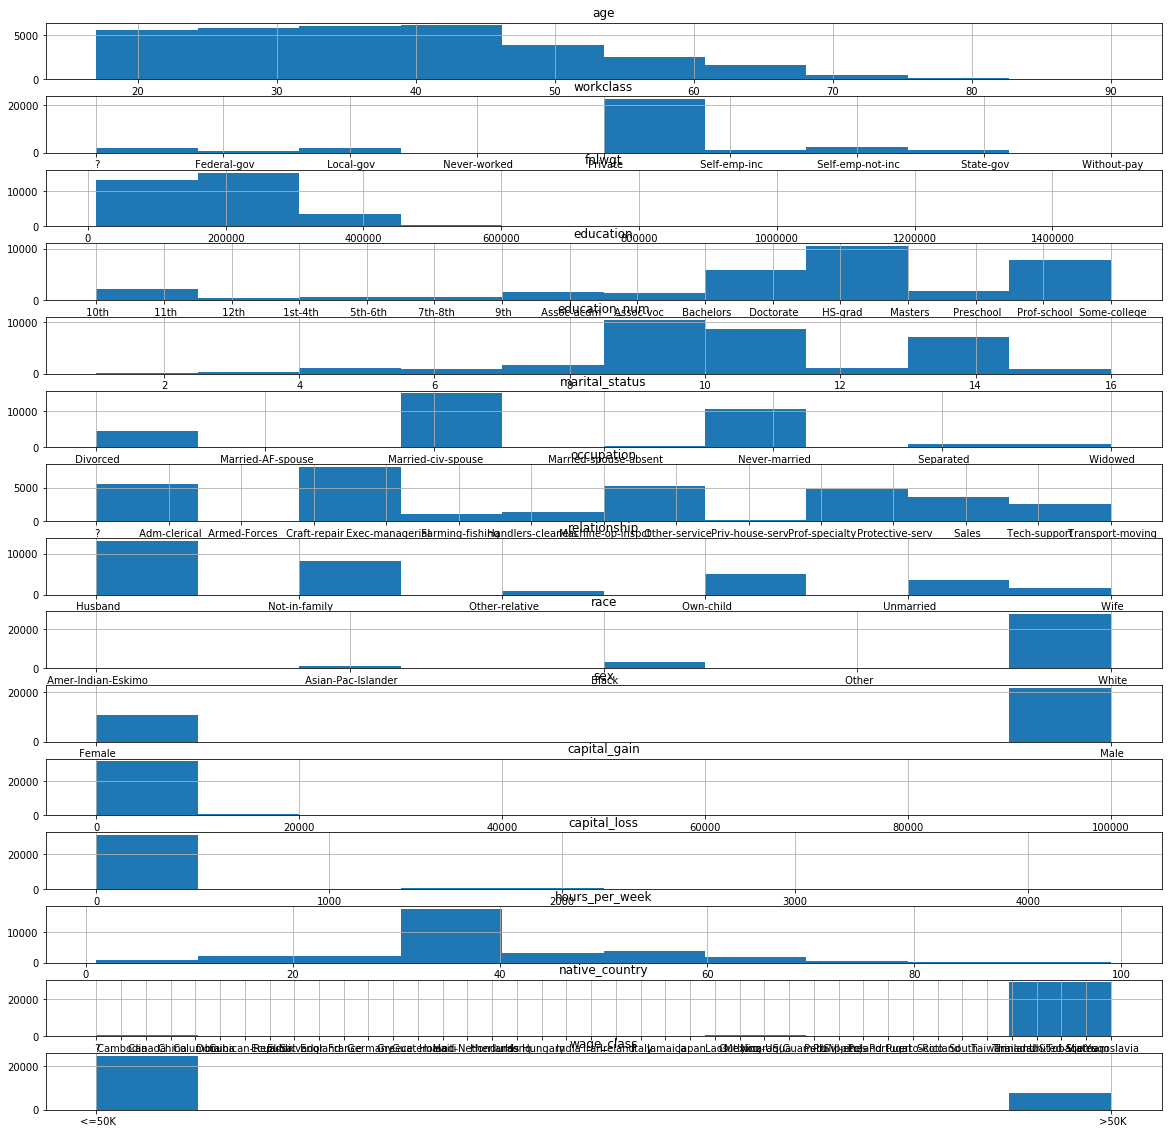

In [7]:
# 快速看下数据的值分布，图中可以看出里面有 ？ 这种值

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

df = train_set
fig, axes = plt.subplots(nrows=len(col_labels), ncols=1, figsize=(20,20))
plt.subplots_adjust(wspace=0.5, hspace=0.3)

row = 0;
for column in df:
    df[column].hist(ax=axes[row])
    axes[row].set_title(column)
    row = row + 1


In [8]:
# 删除带有空值和 ？值的数据
print train_set.shape, train_set.replace(' ?', np.nan).dropna().shape 
print test_set.shape, test_set.replace(' ?', np.nan).dropna().shape 

(32561, 15) (30162, 15)
(16281, 15) (15060, 15)


In [9]:
# 上面看到训练集和测试集中 '50K' 和 '50K.' 两种写法要统一
test_set['wage_class'] = test_set.wage_class.replace({' <=50K.': ' <=50K', ' >50K.':' >50K'})
test_set.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [10]:
# workclass 等字段是字符串，需要做下特征工程转为数值
print train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education_num     32561 non-null int64
marital_status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital_gain      32561 non-null int64
capital_loss      32561 non-null int64
hours_per_week    32561 non-null int64
native_country    32561 non-null object
wage_class        32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None


In [11]:
# 对每一个字符串值，分配一个数值。所以需要把训练集和测试集合并起来用，避免两个集合中同样的字符串分配了不同的数值
combined_set = pd.concat([train_set, test_set], axis = 0) # Stacks them vertically

for feature in combined_set.columns: # Loop through all columns in the dataframe
    if combined_set[feature].dtype == 'object': # Only apply for columns with categorical strings
        combined_set[feature] = pd.Categorical(combined_set[feature]).codes # Replace strings with an integer
        
combined_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48842 entries, 0 to 16280
Data columns (total 15 columns):
age               48842 non-null int64
workclass         48842 non-null int8
fnlwgt            48842 non-null int64
education         48842 non-null int8
education_num     48842 non-null int64
marital_status    48842 non-null int8
occupation        48842 non-null int8
relationship      48842 non-null int8
race              48842 non-null int8
sex               48842 non-null int8
capital_gain      48842 non-null int64
capital_loss      48842 non-null int64
hours_per_week    48842 non-null int64
native_country    48842 non-null int8
wage_class        48842 non-null int8
dtypes: int64(6), int8(9)
memory usage: 3.0 MB


In [12]:
# 字符串型值已经全部变成数值
combined_set.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,7,77516,9,13,4,1,1,4,1,2174,0,40,39,0
1,50,6,83311,9,13,2,4,0,4,1,0,0,13,39,0
2,38,4,215646,11,9,0,6,1,4,1,0,0,40,39,0
3,53,4,234721,1,7,2,6,0,2,1,0,0,40,39,0
4,28,4,338409,9,13,2,10,5,2,0,0,0,40,5,0


In [13]:
# 统一特征工程后，重新拆分回原先的训练集与测试集
train_set = combined_set[:train_set.shape[0]] # Up to the last initial training set row
test_set = combined_set[train_set.shape[0]:] # Past the last initial training set row

In [14]:
print train_set.shape, test_set.shape

(32561, 15) (16281, 15)


训练集和测试集的 feature（特征）都是 14 维度（15 - 1，维度 wage_class 是目标维度，也就是需要分类算法判断的结果）。训练集有 32561 个 sample（样本），测试集有 16281 个 sample。

In [15]:
# 特征工程结束后，下面开始有监督分类算法的流程

# 比赛是预测 wage_class，所以需要把这个字段额外抽出来作为训练的目标类别
y_train = train_set.pop('wage_class')
y_test = test_set.pop('wage_class')

In [16]:
# 使用最常见的 XGBoost 分类算法
import xgboost as xgb
# 算法参数搜索使用 Grid search
from sklearn.grid_search import GridSearchCV

# 需要自动尝试的参数，总共 3 x 3 = 9 种选择
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}

# 固定不变的参数
ind_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}

# Cross Validation = 5，以 accuracy 作为优化目标 
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                             cv_params, 
                             scoring = 'accuracy', cv = 5, n_jobs = -1)

# 开始搜索，要运行一段时间
optimized_GBM.fit(train_set, y_train)

/Users/justinwan/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/justinwan/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

### 上面使用的 accuracy 和其他常用的指标

任何分类算法，对包含两种输入类别（假设是 A 和 B）的数据，有4种可能的分类结果，如下表格所示：

|               | 分类成 A    | 分类成B    |
| ------------- |:----------:| ---------:|
| 真实类别是A     |        TN  |       FP  |
| 真实类别是B     |        FN  |       TP  |

拿其中最常听到 FP（False Positive，假阳。和 FN 代表的假阴一样，‘阴阳’来自医学检测术语）来说，代表有多少 A 被错误划分到 B 类。

4 个数值常常被组合成下面 3 个数值来考核算法准确度：
* Accuracy = (TP + TN) / (TP + TN + FP + FN)
* Recall = TP / (TP + FN)
* Precision = TP / (TP + FP)

In [17]:
# 看下 9 组参数组合中，哪个性能最好
optimized_GBM.grid_scores_

[mean: 0.86957, std: 0.00364, params: {'max_depth': 3, 'min_child_weight': 1},
 mean: 0.86984, std: 0.00340, params: {'max_depth': 3, 'min_child_weight': 3},
 mean: 0.87012, std: 0.00320, params: {'max_depth': 3, 'min_child_weight': 5},
 mean: 0.86515, std: 0.00342, params: {'max_depth': 5, 'min_child_weight': 1},
 mean: 0.86502, std: 0.00139, params: {'max_depth': 5, 'min_child_weight': 3},
 mean: 0.86508, std: 0.00269, params: {'max_depth': 5, 'min_child_weight': 5},
 mean: 0.85977, std: 0.00299, params: {'max_depth': 7, 'min_child_weight': 1},
 mean: 0.85953, std: 0.00301, params: {'max_depth': 7, 'min_child_weight': 3},
 mean: 0.85983, std: 0.00234, params: {'max_depth': 7, 'min_child_weight': 5}]

In [18]:
# 或者自动返回最好的分类算法参数
best_classifier = optimized_GBM.best_estimator_
best_classifier

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=5, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8)

In [19]:
# 系统使用训练集，选中了使用 {'max_depth': 3, 'min_child_weight': 5} 的模型，它的平均 accuracy 是 0.87012
# 我们看下这个模型在测试集上的效果

from sklearn.metrics import accuracy_score
y_pred = best_classifier.predict(test_set) # Predict using our testdmat
y_pred

array([0, 0, 0, ..., 1, 0, 1], dtype=int8)

In [20]:
accuracy_score(y_pred, y_test)

0.87261224740495058

最终的在测试集合上的检测率是 87.26%

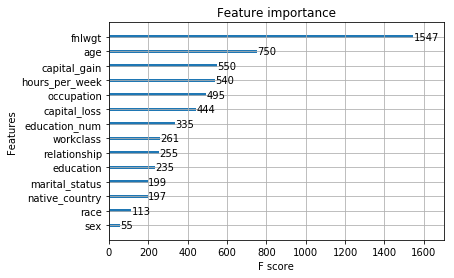

In [21]:
# 我们还可以额外输出了分类算法中，最关键的特征是哪些

from xgboost import plot_importance

plot_importance(best_classifier)
plt.show()